In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

In [2]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'regular'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.family'] = [u'serif']
plt.rcParams['font.size'] = 14

In [3]:
import pandas as pd 
import dataprep.dataset as dp
filename='310_11_more_params.csv'#final_310_311_data.csv'
nsteps=250000#1500000
df = dp.load_reformated_cvs('../data/'+filename,nrows=nsteps)
#df['B:VIMIN'] = df['B:VIMIN'].shift(-1)
#df['B:VIMIN_STD'] = df['B:VIMIN'].rolling(window=15).std()
#df['B:IMINER_STD'] = df['B:IMINER'].rolling(window=15).std()
df = df.set_index(pd.to_datetime(df.time))
df = df.dropna()
df = df.drop_duplicates()
print(len(df))
print(df.keys())

250000
Index(['time', 'file', 'I:IB', 'I:MDAT40', 'I:MXIB', 'B:LINFRQ', 'B:VIMIN',
       'B:IMINER', 'B:VIMAX', 'B:VIPHAS'],
      dtype='object')


In [4]:
import numpy as np 
from sklearn.preprocessing import MinMaxScaler, RobustScaler

## 1 second (cycle - 15Hz)
look_back    = 10*15 
look_forward = 1 
    
def create_dataset(dataset, look_back=1,look_forward=1):
    X, Y = [], []
    offset = look_back+look_forward
    for i in range(len(dataset)-(offset+1)):
        xx = dataset[i:(i+look_back), 0]
        yy = dataset[(i + look_back):(i + offset), 0]
        X.append(xx)
        Y.append(yy)
    return np.array(X), np.array(Y)

def get_dataset(variable='B:VIMIN'):

    dataset = df[variable].values #numpy.ndarray
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    #scaler = RobustScaler()
    dataset = scaler.fit_transform(dataset)

    ## TODO: Fix
    #print(len(dataset))
    train_size = int(len(dataset) * 0.70)
    #print(train_size)
    test_size = len(dataset) - train_size
    #print(test_size)

    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    X_train, Y_train = create_dataset(train, look_back,look_forward)
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    Y_train = np.reshape(Y_train, (Y_train.shape[0],  Y_train.shape[1]))
    #print(X_train.shape)
    #print(Y_train.shape)
    
    X_test, Y_test = create_dataset(test, look_back,look_forward)
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    Y_test = np.reshape(Y_test, (Y_test.shape[0],  Y_test.shape[1]))
    #print(X_test.shape)
    #print(Y_test.shape)
    return scaler, X_train, Y_train, X_test, Y_test

variables = ['B:VIMIN','B:IMINER','B:LINFRQ','B:VIPHAS','I:IB','I:MDAT40','I:MXIB']
#variables = ['B:VIMIN','B:IMINER','B:LINFRQ','I:IB','I:MDAT40']
data_list = []
x_train_list = []
x_test_list = []
for v in range(len(variables)):
    data_list.append(get_dataset(variable=variables[v]))
    x_train_list.append(data_list[v][1])
    x_test_list.append(data_list[v][3])
    
# Axis
concate_axis=1

## Booster model data
BoX_train = np.concatenate(x_train_list,axis=concate_axis) 
BoY_train = np.concatenate((data_list[0][2],data_list[1][2]
                            ,data_list[2][2],data_list[3][2]),axis=1) 
BoX_test = np.concatenate(x_test_list,axis=concate_axis) 
BoY_test = np.concatenate((data_list[0][4],data_list[1][4],
                           data_list[2][4],data_list[3][4]),axis=1) 

print(BoX_train.shape)
print(BoY_train.shape)
#from pickle import dump
# save the scaler
#for v in range(len(variables)):
#    dump(data_list[v][0], open('t0_mmscaker_var{}_nsteps{}k_simple.pkl'.format(v,int(nsteps/1000)), 'wb'))

(174848, 7, 150)
(174848, 4)


In [5]:
import time
from datetime import datetime
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import tensorflow as tf

import src.analysis as ana
import src.models as models
e=250
bs=99
in_shape=(len(variables),150)
out_shape=4
if concate_axis==2:
    in_shape=(1,len(variables)*150)
    
start_time=time.time()
now = datetime.now()
timestamp = now.strftime("D%m%d%Y-T%H%M%S")
print("date and time:", timestamp)
##
save_name='fullbooster_noshift_e{}_bs{}_nsteps{}k_invar{}_outvar{}_axis{}_mmscaler_t0_{}'.format(
    e,bs,int(nsteps/1000),len(variables),out_shape,concate_axis,timestamp)

## Callbacks
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.85, patience=5, min_lr=1e-6,verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=1, mode='auto',
                               baseline=None, restore_best_weights=False)

## Model 
booster_model = models.build_lstm_model(input_shape=in_shape,output_shape=out_shape)
opt = Adam(lr=1e-2,clipnorm=1.0, clipvalue=0.5)
#booster_model.compile(loss='mean_squared_error', optimizer=opt,metrics=['mape','mae'])
booster_model.compile(loss='mse', optimizer=opt,metrics=['mse','mape','mae'])
booster_model.summary()

## Run multiple versions 
histories = []
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=None, shuffle=False)
k=0
for train_index, val_index in kf.split(BoX_train):
    ## Prep data
    x_train, x_val = BoX_train[train_index], BoX_train[val_index]
    y_train, y_val = BoY_train[train_index], BoY_train[val_index]
    print('########################')
    print('### Running {} split. ###'.format(k))
    print('### TrainX shape {}  ###'.format(x_train.shape))
    print('### TrainY shape {}  ###'.format(y_train.shape))
    print('### ValX shape {}  ###'.format(x_val.shape))
    print('### ValY shape {}  ###'.format(y_val.shape))
    print('########################')
    ## Save best model callback
    mcp_name=save_name+'_kfold{}_'.format(k)
    mcp_save = tf.keras.callbacks.ModelCheckpoint(filepath='models/'+mcp_name+'_e{epoch:02d}_vl{val_loss:.5f}.h5')
    ## Run model
    history = booster_model.fit(x_train, y_train, epochs=e, batch_size=bs, validation_data=(x_val,y_val),
                        callbacks=[reduce_lr,early_stopping,mcp_save], verbose=2, shuffle=True)
    histories.append(history)
    k+=1
    print('Current training time: {}'.format(time.time()-start_time))
    
print('Total training time: {}'.format(time.time()-start_time))
booster_model.save('models/'+mcp_name+'_final.h5')

date and time: D10152020-T155756
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 256)            416768    
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 256)            525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 4)                 1028      
Total params: 1,468,420
Trainable params: 1,468,420
Non-trainable params: 0
_________________________________________________________________
########################
### Running 0 split. ###
### TrainX shape (139878, 7, 150)  ###
### TrainY shape (139878, 4)  ###
### ValX shape (34970, 7, 150)  ###
### ValY shape (34970, 4)  ###
#####################

Epoch 00028: early stopping
Current training time: 576.4752149581909
########################
### Running 1 split. ###
### TrainX shape (139878, 7, 150)  ###
### TrainY shape (139878, 4)  ###
### ValX shape (34970, 7, 150)  ###
### ValY shape (34970, 4)  ###
########################
Epoch 1/250
1413/1413 - 20s - loss: 0.2202 - mse: 4.0578e-04 - mape: 36.2887 - mae: 0.0124 - val_loss: 0.2408 - val_mse: 5.5198e-04 - val_mape: 789.4499 - val_mae: 0.0132 - lr: 0.0072
Epoch 2/250
1413/1413 - 20s - loss: 0.2202 - mse: 4.0755e-04 - mape: 9.9903 - mae: 0.0125 - val_loss: 0.2137 - val_mse: 4.9116e-04 - val_mape: 870.4050 - val_mae: 0.0128 - lr: 0.0072
Epoch 3/250
1413/1413 - 20s - loss: 0.2202 - mse: 4.0034e-04 - mape: 19.1176 - mae: 0.0124 - val_loss: 0.2143 - val_mse: 4.9412e-04 - val_mape: 866.3077 - val_mae: 0.0123 - lr: 0.0072
Epoch 4/250
1413/1413 - 20s - loss: 0.2202 - mse: 3.9480e-04 - mape: 33.2047 - mae: 0.0123 - val_loss: 0.2742 - val_mse: 5.1453e-04 - val_mape: 941.5292 - val_mae: 0

1413/1413 - 20s - loss: 0.1198 - mse: 3.1600e-04 - mape: 43.5758 - mae: 0.0106 - val_loss: 0.1122 - val_mse: 5.4757e-04 - val_mape: 720.6613 - val_mae: 0.0131 - lr: 0.0038
Epoch 43/250

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.0032057706150226293.
1413/1413 - 20s - loss: 0.1198 - mse: 3.1598e-04 - mape: 42.6221 - mae: 0.0107 - val_loss: 0.1301 - val_mse: 5.0309e-04 - val_mape: 762.8104 - val_mae: 0.0115 - lr: 0.0038
Epoch 44/250
1413/1413 - 20s - loss: 0.1016 - mse: 3.1170e-04 - mape: 39.1435 - mae: 0.0104 - val_loss: 0.1286 - val_mse: 5.2579e-04 - val_mape: 875.6848 - val_mae: 0.0119 - lr: 0.0032
Epoch 45/250
1413/1413 - 20s - loss: 0.1017 - mse: 3.1384e-04 - mape: 50.2262 - mae: 0.0106 - val_loss: 0.1102 - val_mse: 5.3082e-04 - val_mape: 734.7010 - val_mae: 0.0110 - lr: 0.0032
Epoch 46/250
1413/1413 - 20s - loss: 0.1016 - mse: 3.0826e-04 - mape: 42.8884 - mae: 0.0104 - val_loss: 0.0936 - val_mse: 5.4472e-04 - val_mape: 911.8594 - val_mae: 0.0130 - lr: 0.0032
Epoch 4

Epoch 85/250
1413/1413 - 20s - loss: 0.0631 - mse: 2.7682e-04 - mape: 49.2543 - mae: 0.0098 - val_loss: 0.0659 - val_mse: 5.1106e-04 - val_mape: 625.1264 - val_mae: 0.0110 - lr: 0.0020
Epoch 86/250
1413/1413 - 20s - loss: 0.0631 - mse: 2.7772e-04 - mape: 45.2238 - mae: 0.0098 - val_loss: 0.0577 - val_mse: 5.0401e-04 - val_mape: 603.3088 - val_mae: 0.0106 - lr: 0.0020
Epoch 87/250
1413/1413 - 20s - loss: 0.0631 - mse: 2.7857e-04 - mape: 59.6478 - mae: 0.0099 - val_loss: 0.0699 - val_mse: 5.1190e-04 - val_mape: 481.7798 - val_mae: 0.0111 - lr: 0.0020
Epoch 88/250
1413/1413 - 20s - loss: 0.0631 - mse: 2.7705e-04 - mape: 38.7072 - mae: 0.0098 - val_loss: 0.0788 - val_mse: 5.1263e-04 - val_mape: 507.5194 - val_mae: 0.0107 - lr: 0.0020
Epoch 89/250
1413/1413 - 20s - loss: 0.0631 - mse: 2.7611e-04 - mape: 45.2177 - mae: 0.0098 - val_loss: 0.0661 - val_mse: 5.2904e-04 - val_mape: 569.6441 - val_mae: 0.0114 - lr: 0.0020
Epoch 90/250
1413/1413 - 20s - loss: 0.0631 - mse: 2.7772e-04 - mape: 42.59

Epoch 128/250
1413/1413 - 20s - loss: 0.0330 - mse: 2.5917e-04 - mape: 30.5541 - mae: 0.0093 - val_loss: 0.0414 - val_mse: 5.2632e-04 - val_mape: 477.7222 - val_mae: 0.0107 - lr: 0.0010
Epoch 129/250
1413/1413 - 20s - loss: 0.0330 - mse: 2.5912e-04 - mape: 39.4001 - mae: 0.0093 - val_loss: 0.0348 - val_mse: 5.1351e-04 - val_mape: 591.4392 - val_mae: 0.0104 - lr: 0.0010
Epoch 130/250
1413/1413 - 20s - loss: 0.0330 - mse: 2.5920e-04 - mape: 27.6630 - mae: 0.0093 - val_loss: 0.0305 - val_mse: 5.1593e-04 - val_mape: 462.1412 - val_mae: 0.0108 - lr: 0.0010
Epoch 131/250

Epoch 00131: ReduceLROnPlateau reducing learning rate to 0.0008735420531593263.
1413/1413 - 20s - loss: 0.0330 - mse: 2.5922e-04 - mape: 31.1955 - mae: 0.0093 - val_loss: 0.0364 - val_mse: 5.0929e-04 - val_mape: 410.6242 - val_mae: 0.0109 - lr: 0.0010
Epoch 132/250
1413/1413 - 20s - loss: 0.0281 - mse: 2.5752e-04 - mape: 35.8085 - mae: 0.0092 - val_loss: 0.0351 - val_mse: 5.0623e-04 - val_mape: 515.4822 - val_mae: 0.0103 - 

Epoch 170/250
1413/1413 - 20s - loss: 0.0174 - mse: 2.4934e-04 - mape: 30.9895 - mae: 0.0090 - val_loss: 0.0162 - val_mse: 5.0522e-04 - val_mape: 403.4504 - val_mae: 0.0102 - lr: 5.3646e-04
Epoch 171/250

Epoch 00171: ReduceLROnPlateau reducing learning rate to 0.0004559943830827251.
1413/1413 - 20s - loss: 0.0174 - mse: 2.4959e-04 - mape: 34.5411 - mae: 0.0090 - val_loss: 0.0193 - val_mse: 5.1131e-04 - val_mape: 357.3558 - val_mae: 0.0103 - lr: 5.3646e-04
Epoch 172/250
1413/1413 - 20s - loss: 0.0148 - mse: 2.4837e-04 - mape: 35.1066 - mae: 0.0090 - val_loss: 0.0181 - val_mse: 5.1630e-04 - val_mape: 301.7054 - val_mae: 0.0104 - lr: 4.5599e-04
Epoch 173/250
1413/1413 - 20s - loss: 0.0148 - mse: 2.4888e-04 - mape: 34.8038 - mae: 0.0090 - val_loss: 0.0157 - val_mse: 5.0922e-04 - val_mape: 293.9294 - val_mae: 0.0104 - lr: 4.5599e-04
Epoch 174/250
1413/1413 - 20s - loss: 0.0148 - mse: 2.4816e-04 - mape: 33.0158 - mae: 0.0090 - val_loss: 0.0139 - val_mse: 5.0554e-04 - val_mape: 364.5781 - va

Epoch 211/250
1413/1413 - 20s - loss: 0.0078 - mse: 2.4329e-04 - mape: 32.2109 - mae: 0.0088 - val_loss: 0.0088 - val_mse: 5.0387e-04 - val_mape: 271.4514 - val_mae: 0.0101 - lr: 2.3803e-04
Epoch 212/250
1413/1413 - 20s - loss: 0.0078 - mse: 2.4346e-04 - mape: 28.7261 - mae: 0.0088 - val_loss: 0.0101 - val_mse: 5.0329e-04 - val_mape: 322.7555 - val_mae: 0.0101 - lr: 2.3803e-04
Epoch 213/250
1413/1413 - 20s - loss: 0.0078 - mse: 2.4322e-04 - mape: 27.4907 - mae: 0.0088 - val_loss: 0.0084 - val_mse: 5.1507e-04 - val_mape: 229.2664 - val_mae: 0.0102 - lr: 2.3803e-04
Epoch 214/250
1413/1413 - 20s - loss: 0.0078 - mse: 2.4340e-04 - mape: 27.4688 - mae: 0.0088 - val_loss: 0.0075 - val_mse: 5.0879e-04 - val_mape: 191.2355 - val_mae: 0.0102 - lr: 2.3803e-04
Epoch 215/250

Epoch 00215: ReduceLROnPlateau reducing learning rate to 0.00020232713213772514.
1413/1413 - 20s - loss: 0.0078 - mse: 2.4304e-04 - mape: 34.3092 - mae: 0.0088 - val_loss: 0.0089 - val_mse: 5.0488e-04 - val_mape: 221.4001 - v

1413/1413 - 20s - loss: 0.0037 - mse: 3.0423e-04 - mape: 67.3176 - mae: 0.0092 - val_loss: 0.0039 - val_mse: 2.4615e-04 - val_mape: 162.5364 - val_mae: 0.0088 - lr: 1.0562e-04
Epoch 2/250
1413/1413 - 20s - loss: 0.0037 - mse: 2.9909e-04 - mape: 74.8434 - mae: 0.0091 - val_loss: 0.0045 - val_mse: 2.4511e-04 - val_mape: 148.8774 - val_mae: 0.0088 - lr: 1.0562e-04
Epoch 3/250
1413/1413 - 20s - loss: 0.0037 - mse: 2.9607e-04 - mape: 77.3272 - mae: 0.0091 - val_loss: 0.0037 - val_mse: 2.4856e-04 - val_mape: 185.9253 - val_mae: 0.0088 - lr: 1.0562e-04
Epoch 4/250
1413/1413 - 19s - loss: 0.0037 - mse: 2.9424e-04 - mape: 75.7237 - mae: 0.0091 - val_loss: 0.0033 - val_mse: 2.4858e-04 - val_mape: 162.4686 - val_mae: 0.0088 - lr: 1.0562e-04
Epoch 5/250
1413/1413 - 20s - loss: 0.0037 - mse: 2.9298e-04 - mape: 81.1428 - mae: 0.0091 - val_loss: 0.0040 - val_mse: 2.4926e-04 - val_mape: 187.5636 - val_mae: 0.0088 - lr: 1.0562e-04
Epoch 6/250
1413/1413 - 20s - loss: 0.0037 - mse: 2.9146e-04 - mape: 91.

Epoch 43/250
1413/1413 - 20s - loss: 0.0018 - mse: 2.7499e-04 - mape: 67.9889 - mae: 0.0089 - val_loss: 0.0021 - val_mse: 2.5837e-04 - val_mape: 177.0862 - val_mae: 0.0089 - lr: 4.6862e-05
Epoch 44/250
1413/1413 - 20s - loss: 0.0018 - mse: 2.7505e-04 - mape: 86.2547 - mae: 0.0089 - val_loss: 0.0015 - val_mse: 2.5918e-04 - val_mape: 166.1262 - val_mae: 0.0090 - lr: 4.6862e-05
Epoch 45/250
1413/1413 - 20s - loss: 0.0018 - mse: 2.7487e-04 - mape: 72.7374 - mae: 0.0089 - val_loss: 0.0019 - val_mse: 2.5835e-04 - val_mape: 177.4892 - val_mae: 0.0090 - lr: 4.6862e-05
Epoch 46/250
1413/1413 - 20s - loss: 0.0018 - mse: 2.7470e-04 - mape: 70.3419 - mae: 0.0089 - val_loss: 0.0021 - val_mse: 2.5869e-04 - val_mape: 183.5787 - val_mae: 0.0090 - lr: 4.6862e-05
Epoch 47/250
1413/1413 - 20s - loss: 0.0018 - mse: 2.7440e-04 - mape: 80.6905 - mae: 0.0089 - val_loss: 0.0018 - val_mse: 2.5871e-04 - val_mape: 173.4182 - val_mae: 0.0089 - lr: 4.6862e-05
Epoch 48/250
1413/1413 - 20s - loss: 0.0018 - mse: 2.74

Epoch 84/250
1413/1413 - 20s - loss: 8.9656e-04 - mse: 2.7075e-04 - mape: 76.5067 - mae: 0.0089 - val_loss: 6.4743e-04 - val_mse: 2.6030e-04 - val_mape: 175.4354 - val_mae: 0.0090 - lr: 2.0793e-05
Epoch 85/250
1413/1413 - 20s - loss: 8.8624e-04 - mse: 2.7072e-04 - mape: 68.7686 - mae: 0.0089 - val_loss: 8.8905e-04 - val_mse: 2.6091e-04 - val_mape: 174.3489 - val_mae: 0.0089 - lr: 2.0793e-05
Epoch 86/250

Epoch 00086: ReduceLROnPlateau reducing learning rate to 1.767413095876691e-05.
1413/1413 - 20s - loss: 8.5649e-04 - mse: 2.7086e-04 - mape: 77.1016 - mae: 0.0089 - val_loss: 9.3908e-04 - val_mse: 2.6066e-04 - val_mape: 175.0021 - val_mae: 0.0089 - lr: 2.0793e-05
Epoch 87/250
1413/1413 - 20s - loss: 7.3291e-04 - mse: 2.7054e-04 - mape: 74.2988 - mae: 0.0089 - val_loss: 9.0850e-04 - val_mse: 2.6038e-04 - val_mape: 165.5344 - val_mae: 0.0090 - lr: 1.7674e-05
Epoch 88/250
1413/1413 - 20s - loss: 7.1855e-04 - mse: 2.7052e-04 - mape: 77.1148 - mae: 0.0089 - val_loss: 6.5556e-04 - val_mse: 2

Epoch 123/250

Epoch 00123: ReduceLROnPlateau reducing learning rate to 5.6659210258658275e-06.
1413/1413 - 20s - loss: 4.3608e-04 - mse: 2.6924e-04 - mape: 76.9887 - mae: 0.0089 - val_loss: 3.9927e-04 - val_mse: 2.6070e-04 - val_mape: 169.6809 - val_mae: 0.0089 - lr: 6.6658e-06
Epoch 124/250
1413/1413 - 20s - loss: 4.3396e-04 - mse: 2.6923e-04 - mape: 72.6931 - mae: 0.0089 - val_loss: 3.8082e-04 - val_mse: 2.6084e-04 - val_mape: 170.6289 - val_mae: 0.0090 - lr: 5.6659e-06
Epoch 125/250
1413/1413 - 20s - loss: 4.3383e-04 - mse: 2.6921e-04 - mape: 74.2893 - mae: 0.0089 - val_loss: 4.1023e-04 - val_mse: 2.6059e-04 - val_mape: 170.1764 - val_mae: 0.0090 - lr: 5.6659e-06
Epoch 126/250
1413/1413 - 20s - loss: 4.3374e-04 - mse: 2.6918e-04 - mape: 70.4816 - mae: 0.0089 - val_loss: 4.4830e-04 - val_mse: 2.6097e-04 - val_mape: 166.8725 - val_mae: 0.0090 - lr: 5.6659e-06
Epoch 127/250
1413/1413 - 20s - loss: 4.3384e-04 - mse: 2.6918e-04 - mape: 75.1613 - mae: 0.0089 - val_loss: 4.0256e-04 - val_

Epoch 162/250
1413/1413 - 20s - loss: 3.2186e-04 - mse: 2.6876e-04 - mape: 72.3545 - mae: 0.0088 - val_loss: 3.2500e-04 - val_mse: 2.6090e-04 - val_mape: 168.1699 - val_mae: 0.0090 - lr: 1.8164e-06
Epoch 163/250
1413/1413 - 20s - loss: 3.2188e-04 - mse: 2.6877e-04 - mape: 73.3263 - mae: 0.0088 - val_loss: 3.0077e-04 - val_mse: 2.6091e-04 - val_mape: 168.1198 - val_mae: 0.0090 - lr: 1.8164e-06
Epoch 164/250

Epoch 00164: ReduceLROnPlateau reducing learning rate to 1.5439096216596227e-06.
1413/1413 - 20s - loss: 3.2187e-04 - mse: 2.6875e-04 - mape: 73.1045 - mae: 0.0088 - val_loss: 3.0782e-04 - val_mse: 2.6099e-04 - val_mape: 170.8881 - val_mae: 0.0090 - lr: 1.8164e-06
Epoch 165/250
1413/1413 - 20s - loss: 3.1490e-04 - mse: 2.6873e-04 - mape: 73.3549 - mae: 0.0088 - val_loss: 3.0623e-04 - val_mse: 2.6100e-04 - val_mape: 167.4743 - val_mae: 0.0090 - lr: 1.5439e-06
Epoch 166/250
1413/1413 - 20s - loss: 3.1496e-04 - mse: 2.6874e-04 - mape: 73.8218 - mae: 0.0088 - val_loss: 3.1236e-04 - val_

Epoch 8/250
1413/1413 - 20s - loss: 3.0501e-04 - mse: 2.7322e-04 - mape: 108.3395 - mae: 0.0089 - val_loss: 2.7570e-04 - val_mse: 2.4011e-04 - val_mape: 2.3962 - val_mae: 0.0087 - lr: 1.0000e-06
Epoch 9/250
1413/1413 - 20s - loss: 3.0496e-04 - mse: 2.7318e-04 - mape: 108.4661 - mae: 0.0089 - val_loss: 2.8131e-04 - val_mse: 2.4013e-04 - val_mape: 2.3995 - val_mae: 0.0087 - lr: 1.0000e-06
Epoch 10/250
1413/1413 - 20s - loss: 3.0496e-04 - mse: 2.7315e-04 - mape: 106.7170 - mae: 0.0089 - val_loss: 2.6527e-04 - val_mse: 2.4018e-04 - val_mape: 2.3958 - val_mae: 0.0087 - lr: 1.0000e-06
Epoch 11/250
1413/1413 - 20s - loss: 3.0492e-04 - mse: 2.7312e-04 - mape: 106.5191 - mae: 0.0089 - val_loss: 2.7684e-04 - val_mse: 2.4023e-04 - val_mape: 2.4033 - val_mae: 0.0087 - lr: 1.0000e-06
Epoch 12/250
1413/1413 - 20s - loss: 3.0491e-04 - mse: 2.7309e-04 - mape: 105.7178 - mae: 0.0089 - val_loss: 2.7391e-04 - val_mse: 2.4020e-04 - val_mape: 2.4017 - val_mae: 0.0087 - lr: 1.0000e-06
Epoch 13/250
1413/1413

In [6]:
print(booster_model.metrics_names)
scores = booster_model.evaluate(BoX_test, BoY_test, verbose=1)
print(scores)

['loss', 'mse', 'mape', 'mae']
2339/2339 [==============================] - 13s 6ms/step - loss: 4.8388e-04 - mse: 4.4744e-04 - mape: 107.9619 - mae: 0.0103
[0.00048388319555670023, 0.0004474399611353874, 107.96192169189453, 0.010273585096001625]


In [7]:
print(BoX_test.shape)
print(BoY_test.shape)

(74848, 7, 150)
(74848, 4)


(28,)
(250,)
(193,)
(16,)
(24,)
(511,)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(5000, 4)


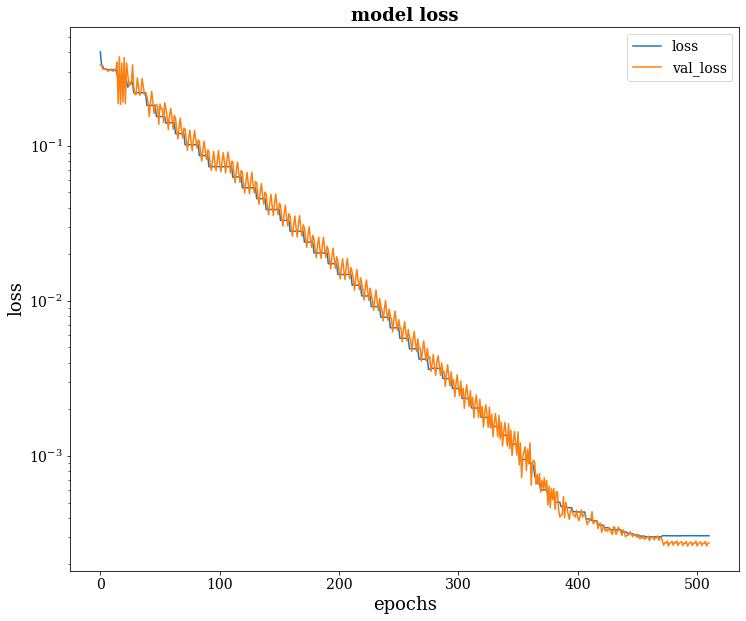

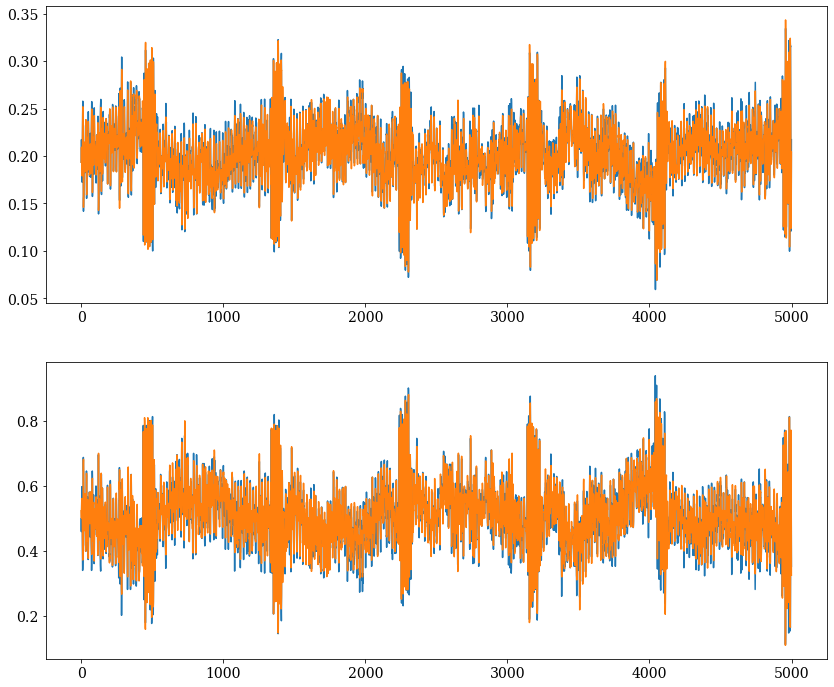

In [8]:
loss_trace = []
vloss_trace = []
for k in range(5):
    fold_histories = np.array(histories[k].history['loss'])
    print(fold_histories.shape)
    loss_trace.append(fold_histories)
    vloss_trace.append(np.array(histories[k].history['val_loss']))

full_loss_trace = np.concatenate(loss_trace)
full_vloss_trace = np.concatenate(vloss_trace)

print(full_loss_trace.shape)
#print(np.array(vloss_trace).flatten())

plt.figure(figsize=(12,10))
plt.plot(full_loss_trace, label='loss')
plt.plot(full_vloss_trace, label='val_loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.yscale('log')
plt.savefig('{}.png'.format('models/loss_{}'.format(save_name)))

ana.plot_test(booster_model,BoX_test,BoY_test,nvar=2,name='models/test_{}'.format(save_name),start=0,end=5000)

(1000, 4)
(1000,)
(1000, 1)
(1000,)
mape ave:0.0035116432700306177
(1000,)
(1000, 1)
(1000,)
mape ave:-159.4609375


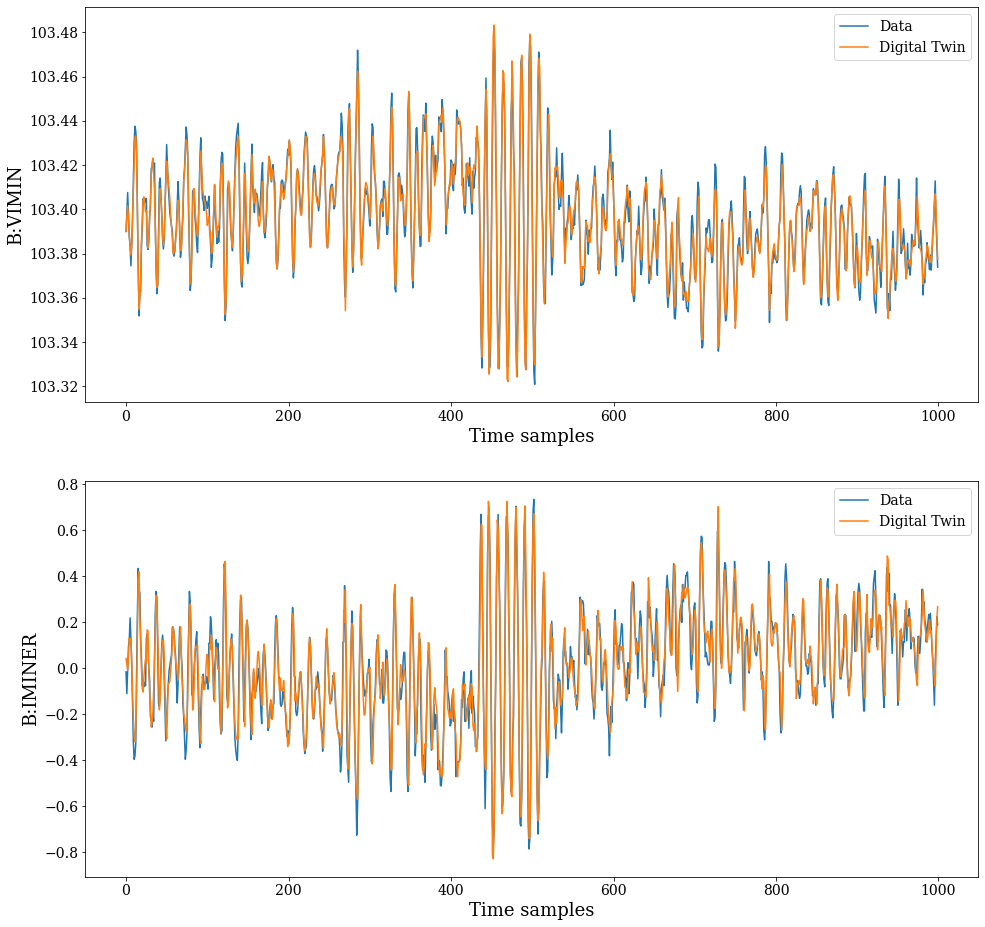

In [9]:
import seaborn as sns
model=booster_model
x_test=BoX_test
y_test=BoY_test
nvar=2
name='test_diff'
start=0
end=1000
x = np.linspace(start,end,int(end-start))
Y_predict = model.predict(x_test[start:end,:,:])
print(Y_predict.shape)
fig, axs = plt.subplots(nvar,figsize=(16,16))
for v in range (nvar):
    Y_test_var1 = data_list[v][0].inverse_transform(y_test[start:end,v].reshape(-1,1))
    Y_predict_var1 = data_list[v][0].inverse_transform(Y_predict[:,v].reshape(-1,1))
    #axs[v].plot(Y_test_var1,Y_predict_var1,'o')
    mape = 100*abs(Y_test_var1-Y_predict_var1)/Y_test_var1
    print(x.shape)
    print(mape.shape)
    mape = mape.reshape(-1,)
    print(mape.shape)
    print('mape ave:{}'.format(mape.mean()))
    axs[v].plot(Y_test_var1,label='Data')
    axs[v].plot(Y_predict_var1, label='Digital Twin')
    #axs[v].fill_between(x, mape, -mape, color='red',edgecolor="black",alpha=0.5) 
    #axs[v].plot(mape)
    #axs[v].set_title(variables[v])
    axs[v].set_ylabel(variables[v])
    axs[v].set_xlabel('Time samples')
    axs[v].legend()
plt.savefig('models/'+mcp_name+'_prediction_final.png')

# plt.savefig('{}.png'.format(name))

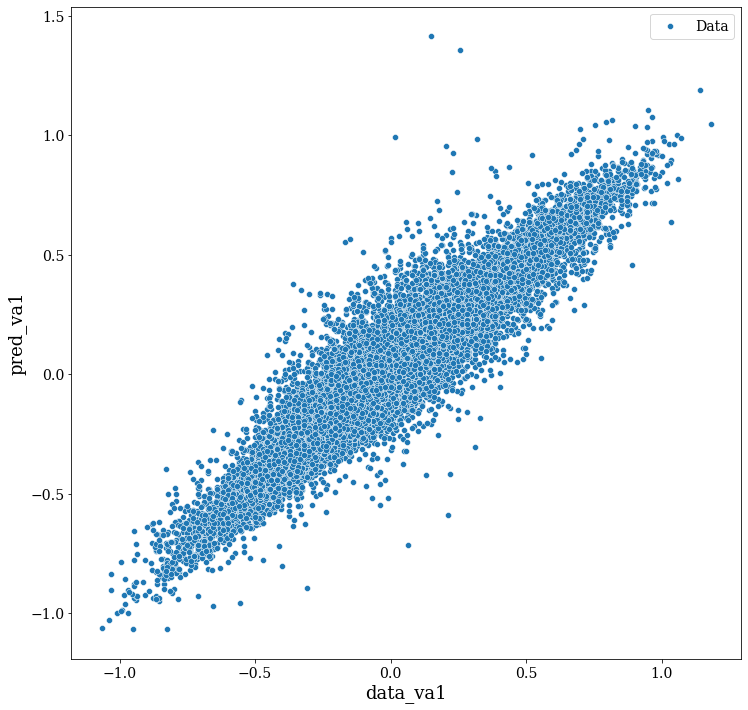

In [14]:
fig, axs = plt.subplots(1,figsize=(12,12))
x_test=BoX_test
y_test=BoY_test
start=0
end=BoX_test.shape[0]
Y_predict = model.predict(x_test[start:end,:,:])
Y_test_var0 = data_list[0][0].inverse_transform(y_test[start:end,0].reshape(-1,1)).reshape(-1,1)
Y_test_var1 = data_list[1][0].inverse_transform(y_test[start:end,1].reshape(-1,1)).reshape(-1,1)
Y_predict_var0 = data_list[0][0].inverse_transform(Y_predict[:,0].reshape(-1,1)).reshape(-1,1)
Y_predict_var1 = data_list[1][0].inverse_transform(Y_predict[:,1].reshape(-1,1)).reshape(-1,1)
np_predict = np.concatenate((Y_test_var0,Y_test_var1,Y_predict_var0,Y_predict_var1),axis=concate_axis) 
df_cool = pd.DataFrame(np_predict,columns=['data_va0','data_va1','pred_va0','pred_va1'])
#sns.pairplot(df_predict)
#np_data = np.concatenate((Y_predict_var0,Y_predict_var1),axis=concate_axis) 
#df_data = pd.DataFrame(np_data)
#sns.pairplot(df_data)
#sns.scatterplot(data=df_cool, x="data_va0", y="data_va1", label='Data')#, hue="time")
#sns.scatterplot(data=df_cool, x="pred_va0", y="pred_va1", label='Digital Twin')#, hue="time")
sns.scatterplot(data=df_cool, x="data_va1", y="pred_va1", label='Data')#, hue="time")

#axs.plot(Y_test_var0,Y_test_var1,'o', label='Data')
#axs.plot(Y_predict_var0,Y_predict_var1,'*', label='Digital Twin')
#axs.set_xlabel('B:VIMIN')
#axs.set_ylabel('B:IMINER')
#axs.set_xlim(103.2,103.6)
plt.savefig('models/'+mcp_name+'_corr_final.png')
#plt.legend()

In [11]:
## 250 gives good results ##

In [12]:
booster_model.save('models/'+mcp_name+'_final.h5')